In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

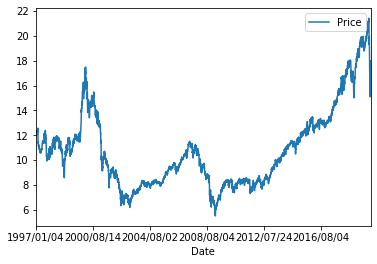

In [57]:
Data = pd.read_csv("Nomura_Global_Equity_Fund.csv")
Data.plot(x='Date', y='Price')

In [106]:
# X percent, Y Days invest strategy Buying Info

def investStrategy(percent, days):
    percentDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    index = 0
    for i in range(days, Data["Price"].size):
        daysArr = np.array(Data["Price"][i - days: i])
        rateOfDates = Data["Price"][i] / daysArr
        smallThenPercent = np.less_equal(rateOfDates, (100 - percent) / 100)
        if (True in smallThenPercent):
            percentDataFrame.loc[index] = [Data["Date"][i], Data["Price"][i]]
            index += 1
#     Ouput csv of buying point info 
#     percentDataFrame.to_csv(str(percent) + "_Percent_" + str(days) + "_Days_Buying_Info.csv")
    return percentDataFrame

def investAvgPrice(dataframe):
    priceArr = np.array(dataframe["Price"])
    priceAvg = np.sum(priceArr) / np.size(priceArr)
    return priceAvg

In [109]:
tenPercentTenDays = investStrategy(10,10)
tenPercentFiveDays = investStrategy(10,5)
fivePercentTenDays = investStrategy(5,10)

avgPriceOfTPTD = investAvgPrice(tenPercentTenDays)
avgPriceOfTPFD = investAvgPrice(tenPercentFiveDays)
avgPriceOfFPTD = investAvgPrice(fivePercentTenDays)

print("tenPercentTenDays avg price : ", avgPriceOfTPTD)
print("tenPercentFiveDays avg price : ", avgPriceOfTPFD)
print("fivePercentTenDays avg price : ", avgPriceOfFPTD)

tenPercentTenDays avg price :  9.91132530120482
tenPercentFiveDays avg price :  10.968
fivePercentTenDays avg price :  10.496696035242291
